In [2]:
%load_ext autoreload
%autoreload 2
    
import config as cfg
from sca import plots, helpers as h

In [57]:
X, y, pts, ks = h.load_data('data/raw/ascadv.h5')
idx = np.random.permutation(len(X))
X, y, pts, ks = X[idx], y[idx], pts[idx], ks[idx]

X_prof, y_prof = X[:-100000], y[:-100000]
X_atck, pts_at, ks_at = X[-100000:], pts[-100000:], ks[-100000:]

In [58]:

import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pl = make_pipeline(
    StandardScaler(),
    RFC(n_estimators=100, max_depth=20, 
        min_samples_leaf=10, n_jobs=-1)
)
pl.fit(X_prof, y_prof)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('standardscaler', ...), ('randomforestclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2


In [69]:
probs = pl.predict_proba(X_atck)

<string>:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


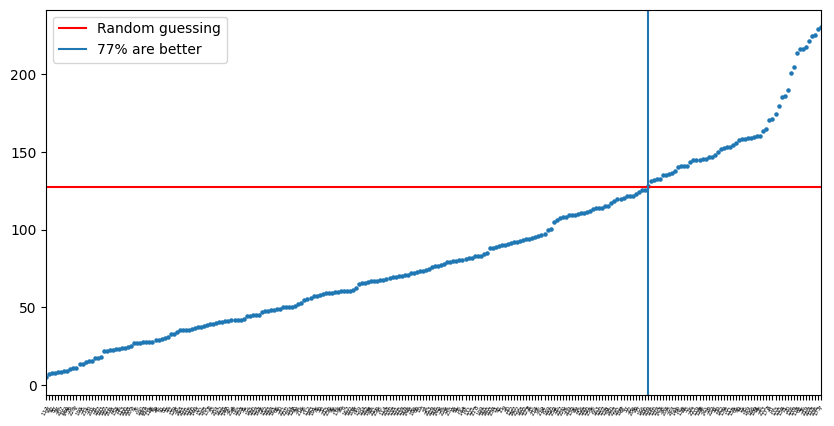

In [126]:
import logging
from tqdm.auto import trange

key, ranks = h.sorted_mr(probs, pts_at, ks_at)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(key.astype(str), ranks, s=5)
# ax.bar(key.astype(str), ranks)
plots.lim(ax, len(key))
plots.ticklabsp(ax, 'x', rot=60, fs=4)

first_worse = np.where(ranks > 127.5)[0][0]
ax.axhline(127.5, color='red', label="Random guessing")
ax.axvline(first_worse, label=f"{first_worse / 256:.0%} are better")

ax.legend()

In [ ]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from tqdm.auto import tqdm

def cv(model, X, y, pts, ks, n_repeats=10):
    rkf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=cfg.SEED)
    med_rank = 0.0
    
    for i, (prof_idx, atk_idx) in enumerate(tqdm(rkf.split(X, y))):
        X_prof, y_prof = X[prof_idx], y[prof_idx]
        X_atk, pts_atk, ks_atk = X[atk_idx], pts[atk_idx], ks[atk_idx]
    
        pl.fit(X_prof, y_prof)
        probs = pl.predict_proba(X_atk)

        _, r = h.sorted_mr(probs, pts_atk, ks_atk)
        mr = np.median(r)
        med_rank += r
        print(f"[{i}] Median Rank: {mr:.3f}")
        
    return mean_rank / n_splits

pl = make_pipeline(
    StandardScaler(),
    RFC(n_estimators=100, max_depth=20, 
        min_samples_leaf=10, n_jobs=-1)
)

X, y, pts, ks = h.load_data('data/raw/ascadv.h5')
mr = cv(pl, X, y, pts, ks )
print(f"Mean guessing entropy (RFC, 10 splits): {mr:.2f}")    

0it [00:00, ?it/s]

[0] Median Rank: 61.906
[1] Median Rank: 55.122
[2] Median Rank: 60.238
[3] Median Rank: 52.731
[4] Median Rank: 69.177
[5] Median Rank: 58.822
